# Bird Sound Recognize

## Value Setting

### Train Value

In [138]:
SOUND_PATH = r"./dataset/raw"
DATASET_PATH = r"./dataset/Tyler_data"
WAV_PATH = r""

MODEL_NAME = "Model_test"

TIME_STEP = 20 
SOUND_LENGTH = 128
TEST_DATA_RATIO = 0.2
INPUT_SHAPE = (TIME_STEP, SOUND_LENGTH)
CLASSES = ["before_net", "build_net","fail", "hug_egg", "out_net", "spawn", "yu_zhu_gi"]

MODEL_CONV1DS = [256, 0, 256]
MODEL_LAYERS_POW = [8, 7, 8, 9, 8]
MODEL_LAYERS = [512, 0, 128, 0, 64, 16]
BATCH_SIZE = 60
EPOCHS = 100
print(MODEL_LAYERS)

[512, 0, 128, 0, 64, 16]


#### debug

## Prepare All Tool

### Prepare Package

In [139]:
# using tensorflow 1.15

# !pip install keras-multi-head
import os
import random
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from tensorflow.keras.layers import Input, TimeDistributed, Dense, Embedding, LayerNormalization
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.layers import MultiHeadAttention
# from transformers import DistilBertTokenizerFast #, TFDistilBertModel
# from transformers import TFDistilBertForTokenClassification
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
import librosa
import librosa.display
import pickle
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import confusion_matrix
print("import package complete")

import package complete


### Sound Proccess Tool

In [140]:
class SoundProcessor:
    def __init__(self):
        self.data = []
        self.sr = None

    def load_sound(self, path):
        self.data, self.sr = librosa.load(path)
        return self.data

    def transform_mfcc(self, data):
        mfcc = librosa.feature.mfcc(y=data, sr=self.sr, n_mfcc=SOUND_LENGTH)
        arr = mfcc.T #分貝
        arr = arr[np.shape(arr)[0] % TIME_STEP:, :]
        return arr

    def plot_mfcc(self, data, save_path):
        arr = librosa.feature.mfcc(y=data, sr=self.sr, dct_type=3)
        arr = arr.T
        mfccArr = arr[np.shape(arr)[0] % TIME_STEP:, :]
        count = 0
        if mfccArr.shape[0] < TIME_STEP:
            print("Arr is too short, ignored.", mfccArr.shape)
            return
        for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP):
            count += 1
            fig, ax = plt.subplots()
            img = librosa.display.specshow(subArr, ax=ax)
            fig.colorbar(img, ax=ax)
            fig.savefig(save_path[:-4] + f"_{count}.png")
            fig.clear()

    def bird_sound_all_classes_json(self, load_folder, save_path):
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        for folder in os.listdir(load_folder):
            load_path = os.path.join(load_folder, folder)
            folderData = []
            for filename in os.listdir(load_path):
                data = self.load_sound(os.path.join(load_path, filename))
                mfccArr = self.transform_mfcc(data)
                if mfccArr.shape[0] < TIME_STEP:
                    print(filename, "arr is too short, ignored.", mfccArr.shape)
                    continue
                for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP):
                    # print("test")
                    # print(len(subArr[0]))
                    folderData.append(subArr.tolist())
                print(filename, " done.")
            split_idx = max(1, int(len(folderData) * TEST_DATA_RATIO))
            random.seed(8787)
            random.shuffle(folderData)
            test_arr = folderData[:split_idx]
            train_arr = folderData[split_idx:]
            # print(test_arr)
            # print(train_arr)
            filename = os.path.join(save_path, folder + ".json")
            with open(filename, "w") as f:
                print(np.array(test_arr).shape)
                print(np.array(train_arr).shape)
                data = {"test": test_arr, "train": train_arr}
                json.dump(data, f)
            print(folder + ".json", " saved.  \n", "Located: ", filename)

        print("Every folder have done!")
        print(f"Save at path: {save_path}")
        print("==================================================================================================")

    def bird_sound_all_classes_npy(self, load_folder, save_path):
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        for folder in os.listdir(load_folder):
            load_path = os.path.join(load_folder, folder)
            folderData = []
            for filename in os.listdir(os.path.join(load_path)):
                data = self.load_sound(os.path.join(load_path, filename))
                mfccArr = self.transform_mfcc(data)
                if mfccArr.shape[0] < TIME_STEP:
                    print(filename, "arr is too short, ignored.", mfccArr.shape)
                    continue
                for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP):
                    folderData.append(subArr)
                print(filename, " done.")
            split_idx = max(1, int(len(folderData) * TEST_DATA_RATIO))
            test_arr = folderData[:split_idx]
            train_arr = folderData[split_idx:]
            random.shuffle(folderData)
            test_npy_folder = os.path.join(save_path, "test")
            train_npy_folder = os.path.join(save_path, "train")
            if not os.path.exists(test_npy_folder):
                os.mkdir(test_npy_folder)
            if not os.path.exists(train_npy_folder):
                os.mkdir(train_npy_folder)
            test_npy_filename = os.path.join(test_npy_folder, folder + ".npy")
            train_npy_filename = os.path.join(train_npy_folder, folder + ".npy")
            np.save(test_npy_filename, np.asarray(test_arr))
            # print(test_arr)
            np.save(train_npy_filename, np.asarray(train_arr))
            print(test_npy_filename, "saved. length:", TIME_STEP, " x ", SOUND_LENGTH)
            print(train_npy_filename, "saved. length:", TIME_STEP, " x ", SOUND_LENGTH)

        print("Every folder have done!")
        print(f"Save at path: {save_path}")
        print("==================================================================================================")

    def instant_transform(self, data):
        mfccArr = self.transform_mfcc(data)
        if mfccArr.shape[0] < TIME_STEP:
            print("Video is too short, can't recognize.")
            return np.array([])
        queue = [subArr for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP)]
        return np.array(queue)

    def load_json(self, load_folder):
        x_train = []
        y_train = []
        x_test = []
        y_test = []
        for y, filename in enumerate(os.listdir(os.path.join(load_folder, "JSON"))):
            load_path = os.path.join(load_folder, "JSON", filename)
            print(load_path)
            data = json.load(open(load_path))
            print(f"{filename} have loaded.")
            x_test += data["test"]
            x_train += data["train"]
            for i in range(len(data["test"])):
                y_test.append(y)
            for i in range(len(data["train"])):
                y_train.append(y)

        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

    def load_npy(self, load_folder):
        x_train = []
        y_train = []
        x_test = []
        y_test = []
        for y, filename in enumerate(os.listdir(os.path.join(load_folder, "NPY", "train"))):
            load_path = os.path.join(load_folder, "NPY", "train", filename)
            print(load_path)
            data = np.load(load_path, allow_pickle=True)
            print(f"{filename} have loaded, shape: ", data.shape)
            x_train += data.tolist()
            for i in range(data.shape[0]):
                y_train.append(y)

        for y, filename in enumerate(os.listdir(os.path.join(load_folder, "NPY", "test"))):
            load_path = os.path.join(load_folder, "NPY", "test", filename)
            print(load_path)
            data = np.load(load_path, allow_pickle=True)
            print(f"{filename} have loaded, shape: ", data.shape)
            x_test += data.tolist()
            for i in range(data.shape[0]):
                y_test.append(y)
        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)


    def plot_bird_sound_all_classes(self, load_folder, save_path):
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        for folder in os.listdir(load_folder):
            if not os.path.exists(os.path.join(save_path, folder)):
                os.mkdir(os.path.join(save_path, folder))
            load_path = os.path.join(load_folder, folder)
            for filename in os.listdir(os.path.join(load_path)):
                path = os.path.join(save_path, folder, filename)
                data = self.load_sound(os.path.join(load_path, filename))
                self.plot_mfcc(data, path)
                print(folder + ".json", " have plot.  \n", "Located: ", path)

        print("Every figure have done!")
        print(f"Save at path: {save_path}")
        print("==================================================================================================")



### Model Create Tool

#### Classes TransForm

In [141]:
def classes_change(mode):
    for i, C in enumerate(CLASSES):
        if i == mode:
            return C
    return "None"

#### Model Basic Functions

In [142]:
def setting(model):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def fit(model, x_train, y_train, x_test, y_test, batch, epochs):
    y_train = to_categorical(y_train, 7)
    y_test = to_categorical(y_test, 7)
    print("START TRAINING==================================================================")
    train_history = model.fit(x=x_train, y=y_train,
                  validation_split=0.2,
                  epochs=epochs,
                  batch_size=batch,
                  verbose=2,
                  validation_data=(x_test, y_test),
                  shuffle=True,
                  )
    return model, train_history

def save(model, save_path, name):
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    tf.saved_model.save(model, os.path.join(save_path, name))
    model.save(os.path.join(save_path, name+".h5"))
    print("Model have saved.")

def load(save_path):
    model = keras.models.load_model(save_path+".h5")
    model.summary()
    return model


#### Create Model

##### Conv1D Model

In [143]:
def createConv1DModel(
        name,
        n_conv1Ds,
        n_layers,
        d_input,
        n_classes):
    """
    @param name: model name
    @param n_conv1Ds: filters of conv1D
    @param n_layers: filters of dense
    @param d_input: input shape
    @param n_classes: output classes
    @return: model
    """
    '''
    MODEL_CONV1DS = [256, 0, 256]
    MODEL_LAYERS = [512, 0, 128, 0, 64, 16]
    '''
    model = Sequential(name=f"{name}")
    model.add(Conv1D(128, kernel_size=3, input_shape=d_input, activation="relu"))
    model.add(MaxPool1D(pool_size=2))
    for i in n_conv1Ds[1:]: #[C, M, D, C, M, / FC, D, FC, D, FC, FC/, FC]
        if i == 0:
            model.add(Dropout(0.2))
        elif i == -1:
            model.add(BatchNormalization())
        else:
            model.add(Conv1D(i, kernel_size=3, activation="relu"))
            model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    for i in n_layers:
        if i == 0:
            model.add(Dropout(0.2))
        else:
            model.add(Dense(i, activation="relu"))
    model.add(Dense(len(n_classes), activation="softmax"))
    model.summary()
    return model


#### Get model

In [144]:
def get_model():
    return createConv1DModel("model",
                  MODEL_CONV1DS,
                  MODEL_LAYERS,
                  INPUT_SHAPE,
                  CLASSES,
                  )


#### Predict Function

In [145]:
def predict_classes(model, data):
    prediction = [np.argmax(arr) for arr in model.predict(data)]
    predict_class = [classes_change(arr) for arr in prediction]
    return prediction, predict_class


#### Test Function

In [146]:

def test(model, x_test, y_test, test_time=10):
    success = 0
    predictions, classes = predict_classes(model, x_test)
    for i in range(test_time):
        index = random.randint(0, len(x_test))
        predict = predictions[index]
        print(f"test{i+1}\t| prediction: ", classes[index], "\n     \t| answer: ", classes_change(y_test[index]))
        if predict == y_test[index]:
            print(f"Match\t| [ O ]")
            success += 1
        else:
            print(f"Match\t| [ X ]")
    print("Accuracy: ", success/test_time, "%.")


#### Plot Model's Accuracy & Loss

In [147]:
def load_history(load_path, name):
    with open(os.path.join(load_path, name+"_history.p"), 'rb') as f:
        history = pickle.load(f)
    print("History have loaded")
    return history


def save_history(history, save_path, name):
  history = history.history
  if not os.path.exists(save_path):
    os.mkdir(save_path)
  with open(os.path.join(save_path, name+"_history.p"), 'wb') as f:
      pickle.dump(history, f)
  print("History have saved")


def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name, is_save=True, save_path=""):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
    # Plot the Graph.
    fig = plt.figure()
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()
    plt.show()
    if not os.path.exists(save_path) and is_save:
      os.mkdir(save_path)

    if is_save and save_path != "":
      fig.savefig(save_path+".png")

def plot_all(model_training_history):
  plot_metric(model_training_history, "loss", "val_loss", "Train Loss Vs Train Val Loss",
        True, os.path.join(DATASET_PATH, "MODEL", MODEL_NAME + "_loss"))
  plot_metric(model_training_history, "acc", "val_acc", "Train Acc Vs Train Val Acc",
        True, os.path.join(DATASET_PATH, "MODEL", MODEL_NAME + "_acc"))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [148]:
def plot(history, save_path, name):
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    print(history.history.keys())
    fig = plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig(os.path.join(save_path, f"{name}_accuracy.png"))

    fig = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig(os.path.join(save_path, f"{name}_loss.png"))


### Main wav proccess

In [149]:
def main_wav_process(mode):
    soundTool = SoundProcessor()
    if mode == "npy":
        soundTool.bird_sound_all_classes_npy(SOUND_PATH, os.path.join(DATASET_PATH, "NPY"))
    elif mode == "json":
        soundTool.bird_sound_all_classes_json(SOUND_PATH, os.path.join(DATASET_PATH, "JSON"))


### Data Loader

In [150]:
def data_loader(mode):
    soundTool = SoundProcessor()
    if mode == "npy":
        x_train, y_train, x_test, y_test = soundTool.load_npy(DATASET_PATH)
    elif mode == "json":
        x_train, y_train, x_test, y_test = soundTool.load_json(DATASET_PATH)
    else:
        print("Please choice data type.")
        return
    return x_train, y_train, x_test, y_test

### Main Training


In [151]:
def main_training(x_train, y_train, x_test, y_test, modelname):
    print("x_train: ", x_train.shape)
    print("y_train: ", y_train.shape)
    print("x_test: ", x_test.shape)
    print("y_test: ", y_test.shape)
    model = get_model()
    model = setting(model)
    model, history = fit(model,
                x_train, y_train,
                x_test, y_test,
                BATCH_SIZE,
                EPOCHS,
                )
    save(model, os.path.join(DATASET_PATH, "MODEL"), modelname)
    #output.clear()
    return model, history


### Main Plot
 

In [152]:
def main_plot(history):
    plot_all(history)

In [153]:
def main_confusion(x_test, y_test):
  y_predict = model.predict(x_test)
  y_pred = y_predict.argmax(axis=-1)
  one_hot_y_test = to_categorical(y_test)
  y_true = one_hot_y_test.argmax(axis=-1)
  target_names = CLASSES
  fig = plt.figure(figsize=(15, 15), dpi=100)
  cnf_martrix = confusion_matrix(y_true, y_pred)

  plot_confusion_matrix(cnf_martrix, classes=target_names, normalize=True,
                      title="bird sound recognize confusion matrix")
  plt.show()

  fig.savefig(f'{DATASET_PATH}/FIGURE/confusion_matrix_{MODEL_NAME}.png')

### Main Testing

In [154]:
def main_testing(x_test, y_test):
    model = load(os.path.join(DATASET_PATH, "MODEL", MODEL_NAME))
    test(model, x_test, y_test, 150)

### Main Test wav


In [155]:
def main_test_wav(wav_path):
    model = load(os.path.join(DATASET_PATH, "MODEL", MODEL_NAME))
    soundTool = SoundProcessor()
    data = soundTool.load_sound(wav_path)
    mfccData = soundTool.instant_transform(data)
    if mfccData.shape[0] != np.array([]).shape[0]:
        predictions, classes = predict_classes(model, mfccData)
        print("Prediction: ", max(classes))

### Main Get MFCC figure

In [156]:
def main_mfcc_figure():
  soundTool = SoundProcessor()
  soundTool.plot_bird_sound_all_classes(SOUND_PATH, os.path.join(DATASET_PATH, "FIGURE"))

## RUN PLACE

In [157]:
# main_wav_process("npy")
main_wav_process("json")

0010.wav  done.
0004.wav  done.
0038.wav  done.
0039.wav  done.
0005.wav  done.
0011.wav  done.
0007.wav  done.
0013.wav  done.
0012.wav  done.
0006.wav  done.
0002.wav  done.
0016.wav  done.
0017.wav  done.
0003.wav  done.
0029.wav  done.
0015.wav  done.
0001.wav  done.
0000.wav  done.
0014.wav  done.
0028.wav  done.
0048.wav  done.
0046.wav  done.
0047.wav  done.
0045.wav  done.
0044.wav  done.
0040.wav  done.
0041.wav  done.
0043.wav  done.
0042.wav  done.
0031.wav  done.
0025.wav  done.
0019.wav  done.
0018.wav  done.
0024.wav  done.
0030.wav  done.
0026.wav  done.
0032.wav  done.
0033.wav  done.
0027.wav  done.
0023.wav  done.
0037.wav  done.
0036.wav  done.
0022.wav  done.
0008.wav  done.
0034.wav  done.
0020.wav  done.
0021.wav  done.
0035.wav  done.
0009.wav  done.
(111, 20, 128)
(444, 20, 128)
fail.json  saved.  
 Located:  ./dataset/Tyler_data/JSON/fail.json
0010.wav  done.
0004.wav  done.
0038.wav  done.
0039.wav  done.
0005.wav  done.
0011.wav  done.
0007.wav  done.
0013.wa

In [158]:
x_train, y_train, x_test, y_test = data_loader("json")

./dataset/Tyler_data/JSON/before_net.json
before_net.json have loaded.
./dataset/Tyler_data/JSON/build_nest.json
build_nest.json have loaded.
./dataset/Tyler_data/JSON/out_nest.json
out_nest.json have loaded.
./dataset/Tyler_data/JSON/hug_egg.json
hug_egg.json have loaded.
./dataset/Tyler_data/JSON/yu_zhu_qi.json
yu_zhu_qi.json have loaded.
./dataset/Tyler_data/JSON/spawn.json
spawn.json have loaded.
./dataset/Tyler_data/JSON/fail.json
fail.json have loaded.


In [159]:
random.seed(None)

In [160]:
min_loss = 100000000
max_acc = 0
each_epoch_loss = []
each_epoch_acc = []
best_loss_epoch = 0
best_acc_epoch = 0
for i in range(30, 31):
    EPOCHS = i
    model, history = main_training(x_train, y_train, x_test, y_test, MODEL_NAME)
    min_loss = min(min_loss, history.history["val_loss"][-1])
    max_acc = max(max_acc, history.history["val_acc"][-1])
    if min_loss == history.history["val_loss"][-1]:
        best_loss_epoch = i
    if max_acc == history.history["val_acc"][-1]:
        best_acc_epoch = i
    each_epoch_loss.append(history.history['val_loss'][-1])
    each_epoch_acc.append(history.history["val_acc"][-1])

print(f"\n\nThe minest loss is {min_loss} \t| It is at epoch {best_loss_epoch}")
print(f"The maxest acc is {max_acc} \t| It is at epoch {best_acc_epoch}")
print()
print(each_epoch_loss)
print(each_epoch_acc)

x_train:  (5296, 20, 128)
y_train:  (5296,)
x_test:  (1323, 20, 128)
y_test:  (1323,)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 18, 128)           49280     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 9, 128)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 7, 256)            98560     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 3, 256)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 768)               0         
_________________________________________

In [161]:
save_history(history, os.path.join(DATASET_PATH, "HISTORY"), MODEL_NAME)

History have saved


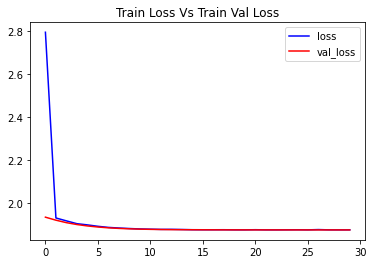

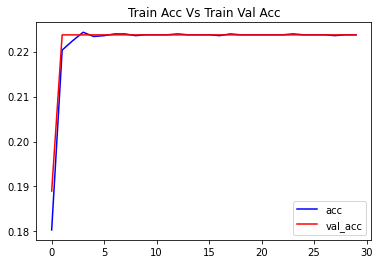

In [162]:
main_plot(history)

In [163]:
main_testing(x_test, y_test)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 18, 128)           49280     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 9, 128)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 7, 256)            98560     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 3, 256)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               393728

Normalized confusion matrix
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


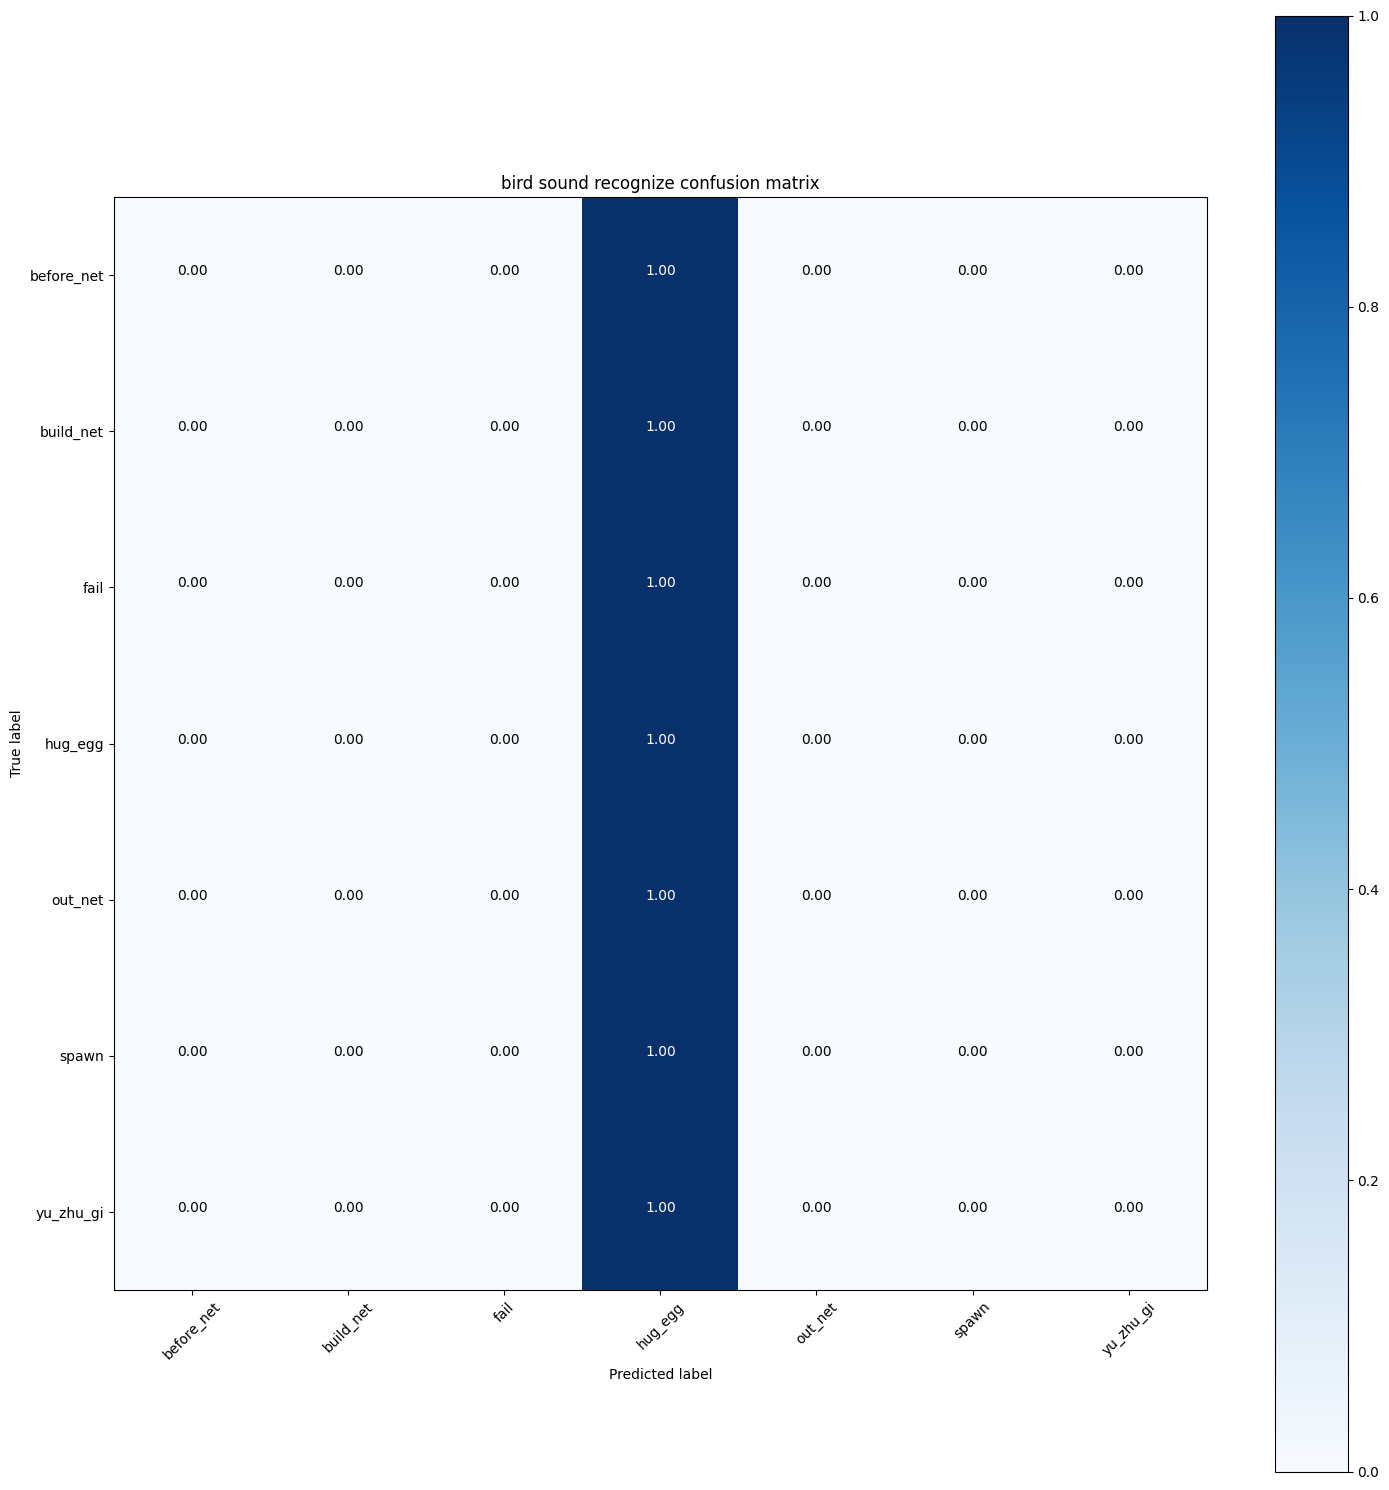

In [164]:
main_confusion(x_test, y_test)